# Optimization RSVD parameters (except the number of iterations)

In [34]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    from scipy.fft import fftn
except:
    !pip install scipy
    from scipy.fft import fftn

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

from collections import namedtuple

try:
    from skimage import io as skimage_io
except:
    !pip install scikit-image
    from skimage import io as skimage_io

In [2]:
#!pip install "self_fourier_shell_correlation @ git+https://github.com/vicente-gonzalez-ruiz/self_fourier_shell_correlation"

In [3]:
from self_fourier_shell_correlation import fsc_utils as fsc

In [4]:
def split_volume(volume):
    """
    Split the volume into two independent half-volumes by dividing the data randomly.
    """
    mask = np.random.randint(0, 2, volume.shape, dtype=bool)
    volume1 = np.where(mask, volume, 0)
    volume2 = np.where(~mask, volume, 0)
    return volume1, volume2

def _split_volume(volume): # NO funciona porque los 2 subvolumenes tienen que tener el mismo shape
    volume1 = volume[:,:,::2]
    volume2 = volume[:,::2,:]
    return volume1, volume2

def compute_spatial_frequencies(shape):
    """
    Compute the spatial frequency grid for a volume of arbitrary shape.
    
    Args:
        shape: Tuple representing the shape of the volume (nx, ny, nz).
        
    Returns:
        freq_radii: A 3D array where each element represents the spatial frequency radius at that point.
    """
    freq_x = np.fft.fftfreq(shape[0])
    freq_y = np.fft.fftfreq(shape[1])
    freq_z = np.fft.fftfreq(shape[2])

    freq_x, freq_y, freq_z = np.meshgrid(freq_x, freq_y, freq_z, indexing='ij')

    freq_radii = np.sqrt(freq_x**2 + freq_y**2 + freq_z**2)

    return freq_radii

def fourier_shell_correlation(volume1, volume2, shell_thickness=1):
    """
    Compute the Fourier Shell Correlation (FSC) between two volumes of arbitrary shape.
    Args:
        volume1, volume2: Two 3D volumes to compare
        shell_thickness: Thickness of Fourier shells in frequency units
    Returns:
        spatial_freq: Array of spatial frequencies (1/voxel units)
        fsc_values: Array of FSC values at each spatial frequency
    """
    # Fourier transforms of both volumes (in double precision and normalized)
    fft1 = fftn(volume1).astype(np.complex128) / np.sqrt(np.prod(volume1.shape))
    fft2 = fftn(volume2).astype(np.complex128) / np.sqrt(np.prod(volume2.shape))

    # Compute spatial frequency grid based on the volume shape
    freq_radii = compute_spatial_frequencies(volume1.shape)

    max_radius = np.max(freq_radii)
    shell_indices = np.arange(0, max_radius, shell_thickness)

    fsc_values = []
    spatial_freq = []

    for r in shell_indices:
        shell_mask = (freq_radii >= r) & (freq_radii < r + shell_thickness)
        
        # Numerator and denominator of the FSC
        num = np.sum(fft1[shell_mask] * np.conj(fft2[shell_mask]))
        denom = np.sqrt(np.sum(np.abs(fft1[shell_mask])**2) * np.sum(np.abs(fft2[shell_mask])**2))
        
        # Handle potential division by zero
        fsc_value = np.abs(num) / denom if denom != 0 else 0
        fsc_values.append(fsc_value)
        spatial_freq.append(r)

    return np.array(spatial_freq), np.array(fsc_values)

def plot_fsc(spatial_freq, fsc_values):
    """
    Plot the Fourier Shell Correlation (FSC) curve.
    """
    plt.plot(spatial_freq, fsc_values, label='FSC')
    plt.axhline(y=0.143, color='r', linestyle='--', label='0.143 threshold')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5 threshold')
    plt.xlabel('Spatial Frequency (1/voxel units)')
    plt.ylabel('FSC')
    plt.title('Fourier Shell Correlation (FSC)')
    plt.legend()
    plt.show()

In [20]:
#vol_name = "/home/vruiz/Downloads/Corbel2301_block2_June2019_crop_june2024_ali_crop.mrc"
vol_name = "/home/vruiz/Downloads/Corbel2301_block2_June2019_crop_ali_crop.mrc"
#vol_name="epfl1_subset1_float.mrc"
#vol_name="small_vol.mrc"
with mrcfile.open(vol_name, permissive=True) as mrc:
    volume = mrc.data
volume = volume[0:100, 0:100, 0:100]

In [67]:
Args = namedtuple("args", "input")
#args = Args("http://www.hpca.ual.es/~vruiz/images/barb.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/zelda.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/boats.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/cameraman.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/couple.png")
args = Args("http://www.hpca.ual.es/~vruiz/images/crowd.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/house.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/lena_512x512_gray.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/mandrill.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/vacas.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/woman1.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/woman_darkhair.png")
#args = Args("http://www.hpca.ual.es/~vruiz/images/lake.png")

In [68]:
x = skimage_io.imread(args.input)  # Ground Truth

In [69]:
volume = np.stack([x[0:100, 0:100]] * 100, axis=0)

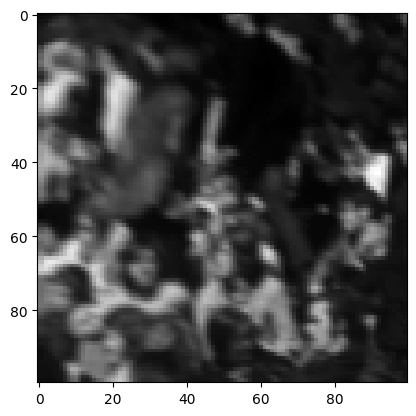

In [70]:
plt.imshow(volume[50], cmap="gray")

In [71]:
print(volume.shape)

(100, 100, 100)


In [72]:
half_volume1, half_volume2 = split_volume(volume)

In [73]:
print(half_volume1.shape, half_volume2.shape)

(100, 100, 100) (100, 100, 100)


In [74]:
spatial_freq, fsc_values = fourier_shell_correlation(half_volume1, half_volume2, shell_thickness=0.1)

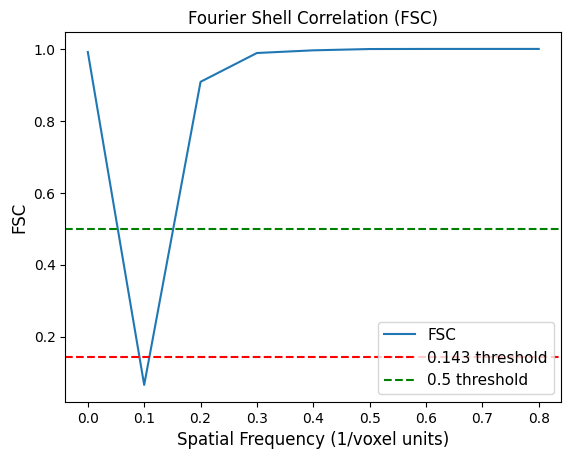

In [75]:
plot_fsc(spatial_freq, fsc_values)

In [76]:
fsc_values

array([0.99140903, 0.06600009, 0.90855142, 0.98866777, 0.99608153,
       0.99968547, 0.99995758, 0.99999691, 1.        ])

In [77]:
y1 = volume
s1 = y1[:, :, ::2]
s2 = y1[:, :, 1::2]
S2 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s2)), 0.5, 0, 0)
s2_shift = np.fft.ifftn(np.fft.ifftshift(S2)).real

s3 = y1[:, ::2, :]
s4 = y1[:, 1::2, :]
S4 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s4)), 0, 0.5, 0)
s4_shift = np.fft.ifftn(np.fft.ifftshift(S4)).real

s5 = y1[::2, :, :]
s6 = y1[1::2, :, :]
S6 = fsc.phase_shift_3d(np.fft.fftshift(np.fft.fftn(s6)), 0, 0, 0.5)
s6_shift = np.fft.ifftn(np.fft.ifftshift(S6)).real

In [78]:
r = volume.shape[0]//2

In [79]:
c1 = fsc.two_volume_fsc(s1, s2_shift, r)
print(c1.shape)
c2 = fsc.two_volume_fsc(s3, s4_shift, r)
c3 = fsc.two_volume_fsc(s5, s6_shift, r)

c_avg = np.mean([c1, c2, c3], axis=0)

freq = fsc.get_radial_spatial_frequencies(s1, 1)

compute_fourier_shell_correlation.shape=(100, 100, 50)
(50,)
compute_fourier_shell_correlation.shape=(100, 50, 100)
compute_fourier_shell_correlation.shape=(50, 100, 100)


In [80]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

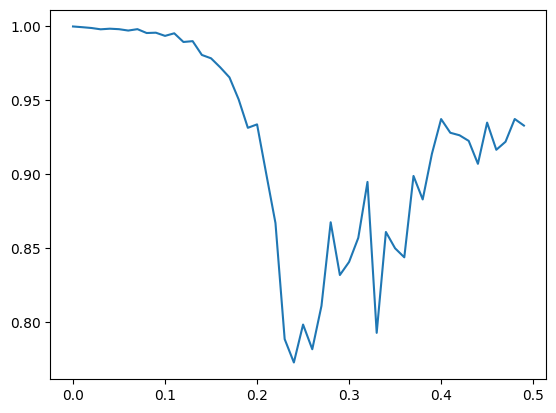

In [81]:
plt.plot(freq, c_avg)

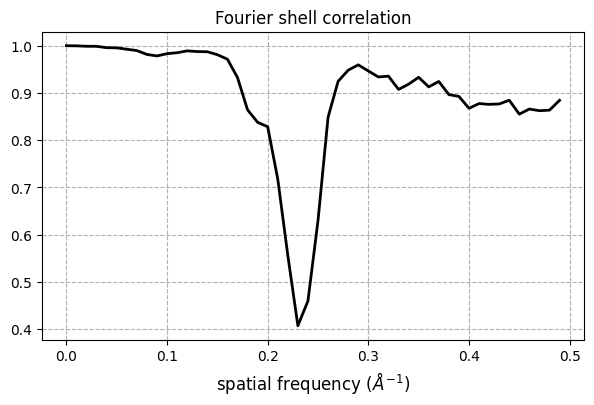

In [65]:
plt.figure(figsize=(7,4))
# plt.plot(freq, c1, color=cmap_a[0], linewidth=2, label='split row')
# plt.plot(freq, c3, color=cmap_a[2], linewidth=2, label='split layer')
# plt.plot(freq, c2, color=cmap_a[3], linewidth=2, label='split column')
plt.plot(freq, c_avg, color='k', linestyle='-', linewidth=2, label='average')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=11)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
# plt.legend()
# plt.savefig('')
plt.show()

In [18]:
#import toupy

In [19]:
#toupy.resolution.FSC.FSCPlot(img1=half_volume1, img2=half_volume1, threshold='halfbit', ring_thick=1, apod_width=20)